# Audio regression using resnet

In [1]:
from src.audio_dataset import AudioRegressionDataset
from src.train import train_regression, lr_decay
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd
import torch
from torchvision.models import resnet34, resnet50, resnet101
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [2]:
dim = "width" #width / height / duration ...

In [3]:
path = str(Path.cwd())
train_path = path + "/data/train/"
valid_path = path + "/data/valid/"

train_data = pd.read_csv(train_path + "train.csv")#[:200]
valid_data = pd.read_csv(valid_path + "valid.csv")#[:40]

train_data["class"] = train_data[dim]
valid_data["class"] = valid_data[dim]

train_data_set = AudioRegressionDataset(train_path, train_data, in_featr='filename', out_featr='class')
valid_data_set = AudioRegressionDataset(valid_path, valid_data, in_featr='filename', out_featr='class')

train_loader = DataLoader(train_data_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data_set, batch_size=16, shuffle=True)

100%|██████████| 540/540 [00:11<00:00, 45.77it/s]


## Set up ResNet model

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')     
resnet_model = resnet34(weights="DEFAULT")
resnet_model.fc = nn.Sequential(nn.Linear(512,2048),
                                nn.Linear(2048,2048),
                                nn.Linear(2048, 1024),
                                nn.Linear(1024, 1024),
                                nn.Linear(1024,1))  # (512, 50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

## Train Model

In [6]:
learning_rate = 1e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50

train_losses = []
valid_losses = []
loss = nn.SmoothL1Loss()

train_regression(resnet_model, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, device, lr_decay, loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 35.09754328166737


  2%|▏         | 1/50 [00:17<14:41, 18.00s/it]

Epoch - 1 Valid-Loss : 21.69977039449355 Valid-MAE : 22.151845932006836
Epoch - 2 Train-Loss : 20.32845376519596


  4%|▍         | 2/50 [00:34<13:32, 16.92s/it]

Epoch - 2 Valid-Loss : 19.16811710245469 Valid-MAE : 19.611186981201172
Epoch - 3 Train-Loss : 19.67969292752883


  6%|▌         | 3/50 [00:50<12:56, 16.51s/it]

Epoch - 3 Valid-Loss : 23.414588984321146 Valid-MAE : 23.906227111816406
Epoch - 4 Train-Loss : 17.463505860637216


  8%|▊         | 4/50 [01:06<12:30, 16.32s/it]

Epoch - 4 Valid-Loss : 18.432459312326767 Valid-MAE : 18.904930114746094
Epoch - 5 Train-Loss : 17.40673311317668


 10%|█         | 5/50 [01:22<12:10, 16.23s/it]

Epoch - 5 Valid-Loss : 16.814158159143783 Valid-MAE : 17.31412124633789
Epoch - 6 Train-Loss : 18.14313875577029


 12%|█▏        | 6/50 [01:38<11:50, 16.15s/it]

Epoch - 6 Valid-Loss : 24.67312723047593 Valid-MAE : 25.0793399810791
Epoch - 7 Train-Loss : 14.25904443860054


 14%|█▍        | 7/50 [01:54<11:32, 16.11s/it]

Epoch - 7 Valid-Loss : 18.69484500324025 Valid-MAE : 19.15993881225586
Epoch - 8 Train-Loss : 13.69019591107088


 16%|█▌        | 8/50 [02:10<11:15, 16.09s/it]

Epoch - 8 Valid-Loss : 16.999996269450467 Valid-MAE : 17.57510757446289
Epoch - 9 Train-Loss : 13.543976201730615


 18%|█▊        | 9/50 [02:26<10:58, 16.07s/it]

Epoch - 9 Valid-Loss : 18.180804897757138 Valid-MAE : 18.754892349243164
Epoch - 10 Train-Loss : 11.845075398683548


 20%|██        | 10/50 [02:42<10:42, 16.05s/it]

Epoch - 10 Valid-Loss : 19.207363970139447 Valid-MAE : 19.73265266418457
Epoch - 11 Train-Loss : 11.134326871703653


 22%|██▏       | 11/50 [02:58<10:25, 16.04s/it]

Epoch - 11 Valid-Loss : 17.736887398888083 Valid-MAE : 18.1422119140625
Epoch - 12 Train-Loss : 11.953778699916953


 24%|██▍       | 12/50 [03:14<10:09, 16.04s/it]

Epoch - 12 Valid-Loss : 18.929314473096063 Valid-MAE : 19.37282943725586
Epoch - 13 Train-Loss : 10.972981254844104


 26%|██▌       | 13/50 [03:30<09:53, 16.03s/it]

Epoch - 13 Valid-Loss : 22.771650426528034 Valid-MAE : 23.228776931762695
Epoch - 14 Train-Loss : 10.65867648580495


 28%|██▊       | 14/50 [03:46<09:36, 16.02s/it]

Epoch - 14 Valid-Loss : 21.822143105899585 Valid-MAE : 22.254127502441406
Epoch - 15 Train-Loss : 10.035847826915628


 30%|███       | 15/50 [04:02<09:20, 16.01s/it]

Epoch - 15 Valid-Loss : 22.800844949834488 Valid-MAE : 23.30375099182129
Epoch - 16 Train-Loss : 10.186349186827155


 32%|███▏      | 16/50 [04:18<09:04, 16.00s/it]

Epoch - 16 Valid-Loss : 22.36714469685274 Valid-MAE : 22.7911376953125
Epoch - 17 Train-Loss : 9.271960370680866


 34%|███▍      | 17/50 [04:34<08:48, 16.00s/it]

Epoch - 17 Valid-Loss : 16.963799644919003 Valid-MAE : 17.49262809753418
Epoch - 18 Train-Loss : 8.304494400234784


 36%|███▌      | 18/50 [04:50<08:32, 16.00s/it]

Epoch - 18 Valid-Loss : 18.148708511801328 Valid-MAE : 18.510793685913086
Epoch - 19 Train-Loss : 7.887514973387999


 38%|███▊      | 19/50 [05:06<08:16, 16.01s/it]

Epoch - 19 Valid-Loss : 17.661331260905545 Valid-MAE : 18.117483139038086
Epoch - 20 Train-Loss : 7.163224590175292


 40%|████      | 20/50 [05:22<08:00, 16.01s/it]

Epoch - 20 Valid-Loss : 18.105536741368912 Valid-MAE : 18.6524600982666
Epoch - 21 Train-Loss : 7.38067785431357


 42%|████▏     | 21/50 [05:38<07:44, 16.01s/it]

Epoch - 21 Valid-Loss : 23.995352380415973 Valid-MAE : 24.49860382080078
Epoch - 22 Train-Loss : 7.564658624284408


 44%|████▍     | 22/50 [05:54<07:29, 16.06s/it]

Epoch - 22 Valid-Loss : 17.472060371847714 Valid-MAE : 18.0550537109375
Epoch - 23 Train-Loss : 8.145135517506038


 46%|████▌     | 23/50 [06:10<07:14, 16.07s/it]

Epoch - 23 Valid-Loss : 19.519736528396606 Valid-MAE : 20.016929626464844
Epoch - 24 Train-Loss : 7.4683128262267395


 48%|████▊     | 24/50 [06:26<06:57, 16.07s/it]

Epoch - 24 Valid-Loss : 18.229002461713904 Valid-MAE : 18.71103858947754
Epoch - 25 Train-Loss : 7.296570574536043


 50%|█████     | 25/50 [06:43<06:42, 16.11s/it]

Epoch - 25 Valid-Loss : 18.453897027408374 Valid-MAE : 18.9919490814209
Epoch - 26 Train-Loss : 7.367322358138421


 52%|█████▏    | 26/50 [06:59<06:26, 16.09s/it]

Epoch - 26 Valid-Loss : 16.917460245244644 Valid-MAE : 17.44355010986328
Epoch - 27 Train-Loss : 6.480227328398648


 54%|█████▍    | 27/50 [07:15<06:09, 16.09s/it]

Epoch - 27 Valid-Loss : 17.739089783500223 Valid-MAE : 18.25162124633789
Epoch - 28 Train-Loss : 7.676457329707987


 56%|█████▌    | 28/50 [07:31<05:53, 16.07s/it]

Epoch - 28 Valid-Loss : 18.409038936390598 Valid-MAE : 18.913740158081055
Epoch - 29 Train-Loss : 6.631849281928119


 58%|█████▊    | 29/50 [07:47<05:37, 16.06s/it]

Epoch - 29 Valid-Loss : 18.577040924745447 Valid-MAE : 18.999197006225586
Epoch - 30 Train-Loss : 6.230104951297536


 60%|██████    | 30/50 [08:03<05:21, 16.07s/it]

Epoch - 30 Valid-Loss : 17.48588783600751 Valid-MAE : 17.892417907714844
Epoch - 31 Train-Loss : 5.425909697132952


 62%|██████▏   | 31/50 [08:19<05:05, 16.06s/it]

Epoch - 31 Valid-Loss : 17.6711145288804 Valid-MAE : 18.015544891357422
Epoch - 32 Train-Loss : 5.328752139911932


 64%|██████▍   | 32/50 [08:35<04:49, 16.06s/it]

Epoch - 32 Valid-Loss : 16.45083975791931 Valid-MAE : 16.94481086730957
Epoch - 33 Train-Loss : 5.909302876276128


 66%|██████▌   | 33/50 [08:51<04:33, 16.08s/it]

Epoch - 33 Valid-Loss : 17.735620386460248 Valid-MAE : 18.179723739624023
Epoch - 34 Train-Loss : 5.526860614909845


 68%|██████▊   | 34/50 [09:07<04:17, 16.11s/it]

Epoch - 34 Valid-Loss : 16.81207098680384 Valid-MAE : 17.279903411865234
Epoch - 35 Train-Loss : 4.849859732038834


 70%|███████   | 35/50 [09:23<04:02, 16.13s/it]

Epoch - 35 Valid-Loss : 16.00723392823163 Valid-MAE : 16.5413818359375
Epoch - 36 Train-Loss : 5.189764017567915


 72%|███████▏  | 36/50 [09:40<03:46, 16.15s/it]

Epoch - 36 Valid-Loss : 16.560471955467673 Valid-MAE : 17.00102424621582
Epoch - 37 Train-Loss : 4.607148984775824


 74%|███████▍  | 37/50 [09:56<03:29, 16.13s/it]

Epoch - 37 Valid-Loss : 17.168850407880896 Valid-MAE : 17.64714241027832
Epoch - 38 Train-Loss : 4.17885280882611


 76%|███████▌  | 38/50 [10:12<03:14, 16.17s/it]

Epoch - 38 Valid-Loss : 17.08331768652972 Valid-MAE : 17.576812744140625
Epoch - 39 Train-Loss : 4.300735582323635


 78%|███████▊  | 39/50 [10:28<02:57, 16.13s/it]

Epoch - 39 Valid-Loss : 16.793147073072547 Valid-MAE : 17.305809020996094
Epoch - 40 Train-Loss : 4.728966875111356


 80%|████████  | 40/50 [10:44<02:40, 16.10s/it]

Epoch - 40 Valid-Loss : 16.476284307592056 Valid-MAE : 17.047361373901367
Epoch - 41 Train-Loss : 4.487467026009279


 82%|████████▏ | 41/50 [11:00<02:24, 16.07s/it]

Epoch - 41 Valid-Loss : 17.07276909491595 Valid-MAE : 17.621788024902344
Epoch - 42 Train-Loss : 4.026038721203804


 84%|████████▍ | 42/50 [11:16<02:08, 16.06s/it]

Epoch - 42 Valid-Loss : 15.744154733770033 Valid-MAE : 16.303939819335938
Epoch - 43 Train-Loss : 3.6268255140851524


 86%|████████▌ | 43/50 [11:32<01:52, 16.05s/it]

Epoch - 43 Valid-Loss : 16.565775380415076 Valid-MAE : 17.015512466430664
Epoch - 44 Train-Loss : 4.294225237387068


 88%|████████▊ | 44/50 [11:48<01:36, 16.05s/it]

Epoch - 44 Valid-Loss : 15.376829568077536 Valid-MAE : 15.822497367858887
Epoch - 45 Train-Loss : 4.794013576034238


 90%|█████████ | 45/50 [12:04<01:20, 16.04s/it]

Epoch - 45 Valid-Loss : 16.21801684884464 Valid-MAE : 16.641347885131836
Epoch - 46 Train-Loss : 5.44157560783274


 92%|█████████▏| 46/50 [12:20<01:04, 16.04s/it]

Epoch - 46 Valid-Loss : 16.974001309450934 Valid-MAE : 17.43067169189453
Epoch - 47 Train-Loss : 4.066859108560226


 94%|█████████▍| 47/50 [12:36<00:48, 16.06s/it]

Epoch - 47 Valid-Loss : 15.77486276626587 Valid-MAE : 16.251754760742188
Epoch - 48 Train-Loss : 4.824002886519713


 96%|█████████▌| 48/50 [12:52<00:32, 16.05s/it]

Epoch - 48 Valid-Loss : 17.839493737501257 Valid-MAE : 18.283388137817383
Epoch - 49 Train-Loss : 4.298565390355447


 98%|█████████▊| 49/50 [13:08<00:16, 16.04s/it]

Epoch - 49 Valid-Loss : 17.97257729137645 Valid-MAE : 18.45064926147461
Epoch - 50 Train-Loss : 4.0551106281140274


100%|██████████| 50/50 [13:24<00:00, 16.10s/it]

Epoch - 50 Valid-Loss : 19.50810194015503 Valid-MAE : 19.94797134399414


## Plot training loss

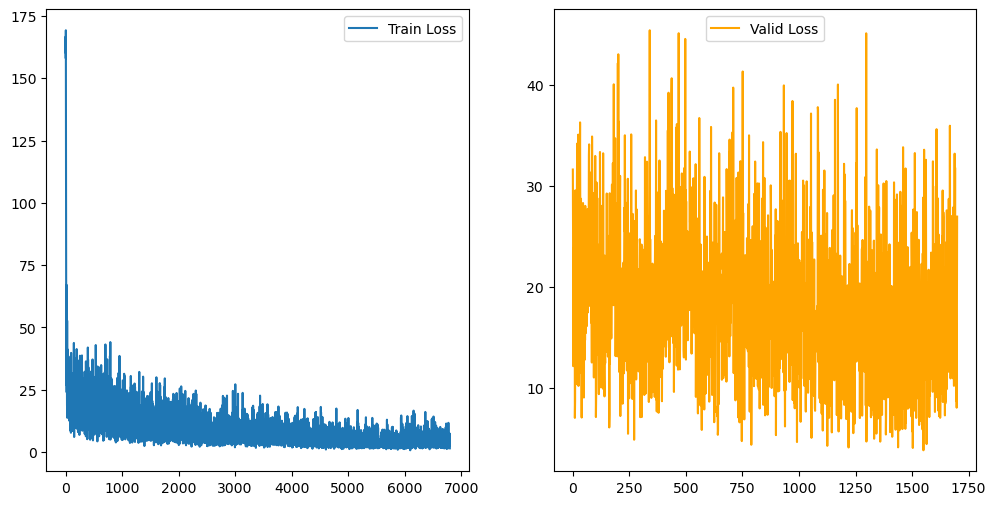

In [7]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
plt.show()